In [1]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
print(tf.__version__)

2.18.0


## data loading

In [3]:
data_path = "TCIR-ALL_2017.h5"
data_info = pd.read_hdf(data_path, key="info", mode='r')
with h5py.File(data_path, 'r') as hf:
    data_matrix = hf['matrix']
    chunk_size = 50  # Adjust based on available memory
    num_chunks = data_matrix.shape[0] // chunk_size + 1
    data_chunks = []
    
    for i in range(num_chunks):
        start_idx = i * chunk_size
        end_idx = min((i + 1) * chunk_size, data_matrix.shape[0])
        data_chunks.append(data_matrix[start_idx:end_idx])
    data_matrix = np.concatenate(data_chunks, axis=0)

In [4]:
data_info.head()

,data_set,ID,lon,lat,time,Vmax,R35_4qAVG,MSLP
0,ATLN,201701L,-50.3,35.8,2017041606,55.0,270.0,992.0
1,ATLN,201701L,-49.9,35.5,2017041609,55.0,270.0,990.0
2,ATLN,201701L,-49.5,35.1,2017041612,55.0,270.0,989.0
3,ATLN,201701L,-49.1,34.8,2017041615,55.0,262.5,988.0
4,ATLN,201701L,-48.7,34.4,2017041618,55.0,255.0,986.0


In [5]:
data_info.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4580 entries, 0 to 4579
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   data_set   4580 non-null   object 
 1   ID         4580 non-null   object 
 2   lon        4580 non-null   float64
 3   lat        4580 non-null   float64
 4   time       4580 non-null   object 
 5   Vmax       4580 non-null   float64
 6   R35_4qAVG  4580 non-null   float64
 7   MSLP       4580 non-null   float64
dtypes: float64(5), object(3)
memory usage: 322.0+ KB


In [6]:
np.shape(data_matrix)

(4580, 201, 201, 4)

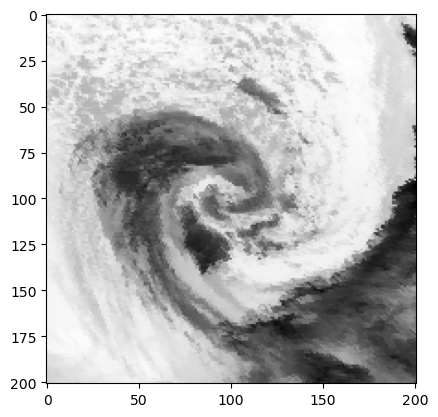

In [7]:
img = data_matrix[4,:,:,0].copy()
fig, ax = plt.subplots()
pos = ax.imshow(img, plt.cm.gray)

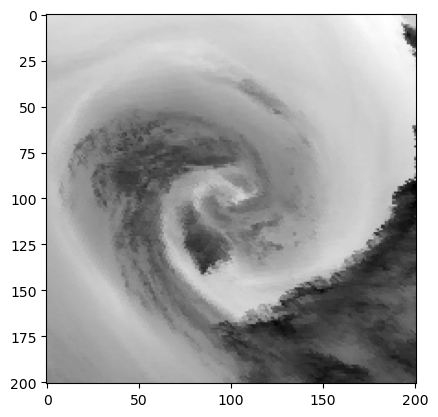

In [8]:
img = data_matrix[4,:,:,1].copy()
fig, ax = plt.subplots()
pos = ax.imshow(img, plt.cm.gray)

In [9]:
data_path_1 = "C:/Users/shrey/Downloads/Cyclone-Prediction-Project-main/Cyclone-Prediction-Project/TCIR-ATLN_EPAC_WPAC.h5"
data_info_1 = pd.read_hdf(data_path_1, key="info", mode='r')
data_info_1.head()

,data_set,ID,lon,lat,time,Vmax,R35_4qAVG,MSLP
0,ATLN,200301L,-66.2,29.1,2003041800,30.0,0.0,1008.0
1,ATLN,200301L,-66.1,29.5,2003041803,30.0,0.0,1008.0
2,ATLN,200301L,-66.0,29.9,2003041806,30.0,0.0,1008.0
3,ATLN,200301L,-65.9,30.4,2003041809,30.0,0.0,1008.0
4,ATLN,200301L,-65.8,30.8,2003041812,30.0,0.0,1008.0


In [10]:
data_path_2 = "C:/Users/shrey/Downloads/Cyclone-Prediction-Project-main/Cyclone-Prediction-Project/TCIR-CPAC_IO_SH.h5"
data_info_2 = pd.read_hdf(data_path_2, key="info", mode='r')
data_info_2.head()
print(len(data_info), len(data_info_1), len(data_info_2))

4580 47381 23118


Is there missing value?

In [12]:
data_info.isna().sum(axis=0)
data_info_1.isna().sum(axis=0)
data_info_2.isna().sum(axis=0)

data_set     0
ID           0
lon          0
lat          0
time         0
Vmax         0
R35_4qAVG    0
MSLP         0
dtype: int64

In [13]:
data_info.data_set.unique()
data_info_1.data_set.unique()
data_info_2.data_set.unique()

array(['CPAC', 'IO', 'SH'], dtype=object)

In [14]:
data_info.groupby('ID').count()
data_info_1.groupby('ID').count().head()
data_info_2.groupby('ID').count().head()

,data_set,lon,lat,time,Vmax,R35_4qAVG,MSLP
ID,,,,,,,
200301C,49,49,49,49,49,49,49
200301I,89,89,89,89,89,89,89
200302I,61,61,61,61,61,61,61
200303I,39,39,39,39,39,39,39
200311S,91,91,91,91,91,91,91


In [15]:
data_info_1.iloc[-1]
data_info_2.iloc[-1]

data_set             SH
ID              201620S
lon               190.7
lat               -13.5
time         2016042406
Vmax               30.0
R35_4qAVG           0.0
MSLP             1000.0
Name: 23117, dtype: object

In [16]:
data_info = data_info.assign(time=pd.to_datetime(data_info.time, format=r'%Y%m%d%H'))

Is it true that for every ID the increase in time is 3 hours?

In [18]:
data_info[['ID', 'time']].groupby('ID').diff().nunique()

time    1
dtype: int64

In [19]:
data_info_1 = data_info.assign(time=pd.to_datetime(data_info_1.time, format=r'%Y%m%d%H'))
data_info_2 = data_info.assign(time=pd.to_datetime(data_info_2.time, format=r'%Y%m%d%H'))

In [20]:
data_info_1[['ID', 'time']].groupby('ID').diff().nunique()
data_info_2[['ID', 'time']].groupby('ID').diff().nunique()

time    85
dtype: int64

## Data preprocessing

In [22]:
## keep only IR and PMW
X_irpmw = data_matrix[:,:,:,0::3]
y = data_info['Vmax'].values[:,np.newaxis]

In [23]:
X_irpmw[np.isnan(X_irpmw)] = 0
X_irpmw[X_irpmw > 1000] = 0

In [24]:
train_x, test_x, train_y, test_y = train_test_split(X_irpmw, y, random_state = 101, test_size=0.2)

In [44]:
# kf = KFold(n_splits=2)
# for train_index, test_index in kf.split(X_irpmw):
#     print("TEST:", len(list(train_index)), type(list(test_index)))
#     X_train, X_test = X_irpmw[train_index], X_irpmw[test_index]
#     y_train, y_test = y[train_index], y[test_index]
X_tensor = tf.convert_to_tensor(X_irpmw) 
y = tf.convert_to_tensor(y)

X_tensor = tf.convert_to_tensor(X_irpmw)
y = tf.convert_to_tensor(y)

### Standardization

In [47]:
X_std = tf.image.per_image_standardization(X_tensor)

In [48]:
img = X_std[0,:,:,:]
print(np.mean(img), np.std(img))

-3.965676e-08 1.0


## Preprocessing layers

In [50]:
class Preprocessing(keras.layers.Layer):
    def __init__(self):
        super(Preprocessing, self).__init__()
    def call(self, inputs, training=None):
        if training:
            inputs = tf.image.rot90(inputs, k=np.random.randint(4))
        return tf.image.central_crop(inputs, 0.5)

In [51]:
pp = Preprocessing()

In [52]:
rotated = pp(X_std[:5,:,:,:], training=True)

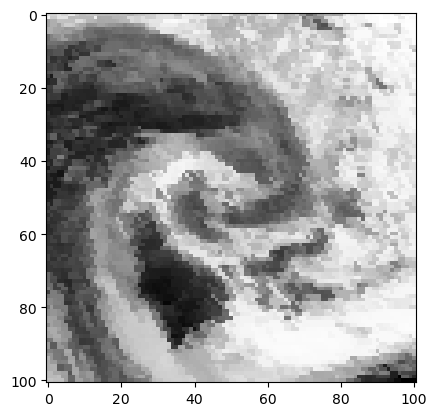

In [53]:
fig, ax = plt.subplots()
pos = ax.imshow(rotated[4,:,:,0], plt.cm.gray)

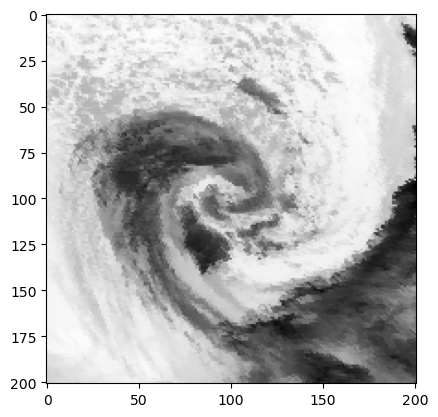

In [54]:
fig, ax = plt.subplots()
pos = ax.imshow(X_std[4,:,:,0], plt.cm.gray)

## Building a model

In [56]:
X_std[list(np.array([0,1,2]))]

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([ 1.1870103, -1.0012519], dtype=float32)>

In [75]:
# input_size = len(X_std)
# output_size = 10

"""
references: 
layers API: https://keras.io/api/layers/ 

1. some parameter tuning: 
    batch size: BATCH_SIZE = 128 #@param ["64", "128", "256", "512"]
    regularizer: l1,l2 
    how to set the initial weight: weights_initializer = keras.initializers.GlorotUniform()  
    batch size: 32 
    how to choose metric?  https://www.tensorflow.org/guide/keras/train_and_evaluate  
        right now, I am using mse. 
    what is callback?  https://keras.io/api/callbacks/  
3. 3 fold cross-validation 
4. hold out data for testing 
5. all years data 
"""



#A function that trains and validates the model and returns the MSE
def train_val_model(train_x,train_y,val_x,val_y, n_epochs, batch_size):
    reg_param = 1e-5
    
    train_X = tf.convert_to_tensor(train_x)
    train_Y = tf.convert_to_tensor(train_y)
    train_X = tf.image.per_image_standardization(train_X)
    
    val_X = tf.convert_to_tensor(val_x)
    val_Y = tf.convert_to_tensor(val_y)
    val_X = tf.image.per_image_standardization(val_X)
    
    weights_initializer = keras.initializers.GlorotUniform()
    

    model = keras.models.Sequential([
        Preprocessing(),
        keras.layers.Conv2D(filters=16, kernel_size=4, strides=2, padding='valid', activation='relu', kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
        keras.layers.Conv2D(filters=32, kernel_size=3, strides=2, padding='valid', activation='relu', kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
        keras.layers.Conv2D(filters=64, kernel_size=3, strides=2, padding='valid', activation='relu', kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
        keras.layers.Conv2D(filters=128, kernel_size=3, strides=2, padding='valid', activation='relu', kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
        keras.layers.Flatten(),
        keras.layers.Dense(256, activation='relu', kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
        keras.layers.Dense(128, activation='relu', kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
        keras.layers.Dense(1, activation='relu', kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
    ])
    
    #Compiling the model
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=5e-4, beta_1=0.99, beta_2=0.9999),
                  loss='mean_squared_error', #Computes the mean of squares of errors between labels and predictions
                  metrics=['mean_squared_error'], #Computes the mean squared error between y_true and y_pred
                 )
    # initialize TimeStopping callback 
#     time_stopping_callback = tfa.callbacks.TimeStopping(seconds=5*60, verbose=1)
    
    #Training the network
    history = model.fit(train_X,train_Y, 
         epochs=n_epochs,
         batch_size=batch_size, 
         verbose=1,
         validation_split=0.1,
         #callbacks=[tf.keras.callbacks.TensorBoard(run_dir + "/Keras"), time_stopping_callback]
        )
    
    val_score = model.evaluate(val_X, val_Y)
    print("Val Score: ",val_score)
    return history,val_score

In [76]:
from sklearn.model_selection import KFold

n_epochs=200
batch_size=64
model_history = []  #save the model history in a list after fitting so that we can plot later
val_scores=[]
kf = KFold(n_splits=5)

i=0
for train_index, test_index in kf.split(X_irpmw):
    print("Training on Fold: ",i+1)
    i+=1
    train_x, val_x = X_irpmw[train_index], X_irpmw[test_index]
    train_y = tf.gather(y, train_index)
    val_y = tf.gather(y, test_index)
    history,val_score = train_val_model(train_x,train_y,val_x,val_y, n_epochs, batch_size)
    model_history.append(history)
    val_scores.append(val_score)
    print("======="*12, end="\n\n\n")

Training on Fold:  1
Epoch 1/200

52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - loss: 1585.3320 - mean_squared_error: 1585.3243 - val_loss: 986.6470 - val_mean_squared_error: 986.6400
Epoch 2/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 683.7365 - mean_squared_error: 683.7297 - val_loss: 420.5560 - val_mean_squared_error: 420.5498
Epoch 3/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 590.2677 - mean_squared_error: 590.2618 - val_loss: 297.2703 - val_mean_squared_error: 297.2647
Epoch 4/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 575.0434 - mean_squared_error: 575.0379 - val_loss: 371.3582 - val_mean_squared_error: 371.3528
Epoch 5/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 526.4473 - mean_squared_error: 526.4420 - val_loss: 326.9311 - val_mean_squared_error: 326.9257
Epoch 6/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 442.1244 - mean_squared_error: 442.1190 - val_loss: 399.3589 - val_mean_squared_error: 399.3535
Epoch 7/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 2

In [77]:
def plot_xy(history,title):
    fig = plt.figure()
    x=range(n_epochs)
    train_mse=history.history['loss']
    val_mse=history.history['val_loss']
    plt.plot(x,train_mse,label="train_mse")
    plt.plot(x,val_mse,label="val_mse")
    plt.xlabel('epochs')
    plt.ylabel('mse (kt^2)')
    plt.title(title)
    plt.legend()

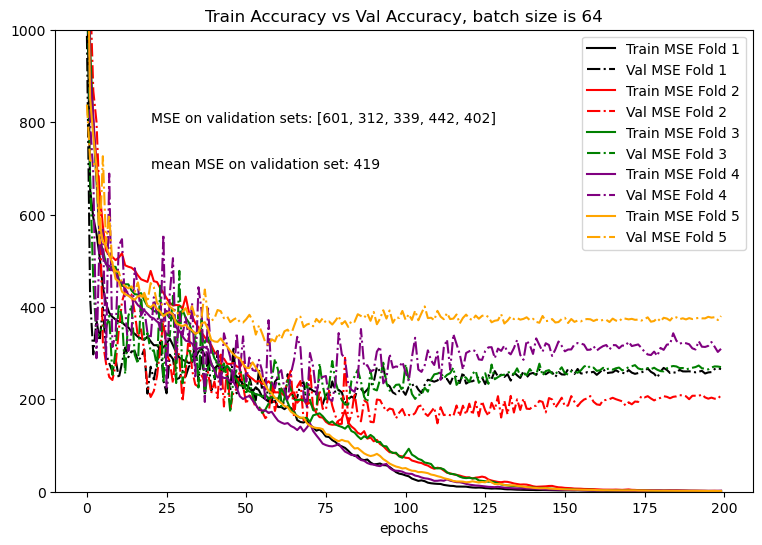

In [78]:
plt.figure(figsize=(9,6))
plt.title('Train Accuracy vs Val Accuracy, batch size is 64')
colors=['black','red','green','purple','orange']
for i in range(5):
    plt.plot(model_history[i].history['mean_squared_error'], label='Train MSE Fold '+str(i+1), color=colors[i])
    plt.plot(model_history[i].history['val_mean_squared_error'], label='Val MSE Fold '+str(i+1), color=colors[i], linestyle = "dashdot")

plt.legend(loc='upper right')
plt.xlabel('epochs')
plt.ylim(0,1000)
plt.text(20,800,"MSE on validation sets: "+str([int(v) for v,v2 in val_scores]))
plt.text(20,700,"mean MSE on validation set: "+str(int(np.mean(val_scores,axis=0)[0])))
plt.show()

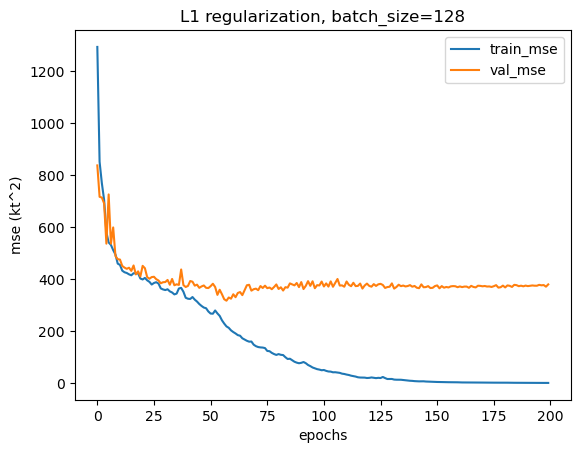

In [79]:
plot_xy(history,"L1 regularization, batch_size=128")

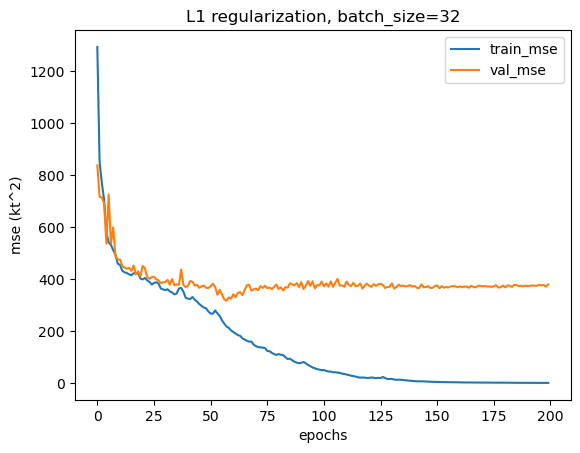

In [80]:
plot_xy(history,"L1 regularization, batch_size=32")

In [110]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

# Load and preprocess MNIST dataset as an example
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Normalize data and reshape to fit CNN input
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
x_train = np.expand_dims(x_train, axis=-1)  # Convert to (batch, height, width, channels)
x_test = np.expand_dims(x_test, axis=-1)

# Split validation data from training set
x_val, y_val = x_train[-10000:], y_train[-10000:]
x_train, y_train = x_train[:-10000], y_train[:-10000]

# Hyperparameters
reg_param = 1e-5
weights_initializer = keras.initializers.GlorotUniform()

# Model Definition with Input Layer
model = keras.models.Sequential([
    keras.layers.Input(shape=(28, 28, 1)),  # Ensures proper input shape
    keras.layers.Conv2D(filters=16, kernel_size=3, strides=1, padding='same', activation='relu',
                        kernel_initializer=weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),  # Reduces feature map size
    
    keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu',
                        kernel_initializer=weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),  
    
    keras.layers.Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu',
                        kernel_initializer=weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),  

    keras.layers.Flatten(),
    keras.layers.Dense(256, activation='relu', kernel_initializer=weights_initializer,
                       kernel_regularizer=keras.regularizers.l2(reg_param)),
    keras.layers.Dense(128, activation='relu', kernel_initializer=weights_initializer,
                       kernel_regularizer=keras.regularizers.l2(reg_param)),
    keras.layers.Dense(10, activation='softmax')  # 10 classes for MNIST
])

# Compile Model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=5e-4, beta_1=0.99, beta_2=0.9999),
              loss='sparse_categorical_crossentropy',  # Changed for multi-class classification
              metrics=['accuracy'])

# Print Model Summary
model.summary()

# Train Model
print("Fit model on training data")
history = model.fit(
    x_train, y_train,
    batch_size=64,
    epochs=2,
    validation_data=(x_val, y_val),
)

# Evaluate Model
print("Evaluate on test data")
results = model.evaluate(x_test, y_test, batch_size=128)
print("Test loss, Test accuracy:", results)

# Generate Predictions
print("Generate predictions for 3 samples")
predictions = model.predict(x_test[:3])
print("Predictions shape:", predictions.shape)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_32 (Conv2D)              │ (None, 28, 28, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 14, 14, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 7, 7, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 256)            │       147,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,194 (801.54 KB)

 Trainable params: 205,194 (801.54 KB)

 Non-trainable params: 0 (0.00 B)

Fit model on training data
Epoch 1/2
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.7938 - loss: 0.7072 - val_accuracy: 0.9766 - val_loss: 0.0851
Epoch 2/2
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9767 - loss: 0.0819 - val_accuracy: 0.9823 - val_loss: 0.0660
Evaluate on test data
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9830 - loss: 0.0644
Test loss, Test accuracy: [0.0559702031314373, 0.9848999977111816]
Generate predictions for 3 samples
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
Predictions shape: (3, 10)


In [111]:
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_32 (Conv2D)              │ (None, 28, 28, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 14, 14, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 7, 7, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 256)            │       147,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 615,584 (2.35 MB)

 Trainable params: 205,194 (801.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 410,390 (1.57 MB)

In [112]:
print("GPU Available: ", tf.test.is_gpu_available())

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU Available:  False
